# Movie-Recommender

In this project, we address the needs of a hypothetical movie streaming business looking to increase revenue. The business is new to online streaming and wants to compete with larger well known online streaming businesses.  Using the <a href="https://grouplens.org/datasets/movielens/latest/">MovieLens dataset</a> and well established data science techniques, we build movie recommendation engines using both collaborative and content based filtering. By accurately predicting sound movie recommendations to subscribers, subscribers will stay on the streaming platform longer and remain customers longer. It can also present an opportunity for ad based revenue targeting customers on the platform. Furthermore, satisfied customers are more likely to recommend the streaming service to family and friends. 

## Import Packages
These are the packages we used for our project. The environment file provided should supply all of these packages to work on your machine except for Apache Spark, which requires a bit of work to install onto your computer. You can follow <a href="https://www.datacamp.com/community/tutorials/installation-of-pyspark">this tutorial</a> from <a href="https://www.datacamp.com">Datacamp</a> to install Spark

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import rec_functions as rf

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, max, avg
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Start a spark session
spark = SparkSession.builder.getOrCreate()

## Data

The data set used for this project is the  <a href="https://grouplens.org/datasets/movielens/latest/">MovieLens dataset</a> from the GroupLens research lab at the University of Minnesota. It contains 100,835 unique viewer ratings, 610 individual viewers, and 9,724 movies.

The dataset is a clean dataset containing four CSV files:
1. `links.csv` (9742, 3):
Is a csv file containing 3 columns, `movieId`, `imdbId`, `tmdbId` with 9742 rows. Each row represents a unique movie.
2. `movies.csv` (9742, 3):
Is a csv file containing 3 columns, `movieId`, `title`, and `genre` with 9742 rows. Each row represents a unique movie
3. `ratings.csv` (100836, 4):
Is a csv file containg 4 `columns`, `userId`,	`movieId`, `rating`, `timestamp` with 100836 rows. Each row represents a `rating` from a `userID` assigned to a `movieID`
4. `tags.csv` (3683, 4):
Is a csv file containing 4 columns, `userId`,	`movieId`,	`tag`,	`timestamp` with 2683 rows. Each row represents a `timestamp` a `userID` gave assigned a `movieID` a `tag`.

### Import Data

CSV files are imported and converted to both Pandas and Spark data frames, and are extensively used in this project.

In [2]:
# Download the data

# ! wget -P ../../data http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [3]:
# Unzip the data

with zipfile.ZipFile('../../data/ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('../../data')

In [4]:
# Read in the data with spark DataFrames
links = spark.read.csv('../../data/ml-latest-small/links.csv', inferSchema=True, header=True)
movies = spark.read.csv("../../data/ml-latest-small/movies.csv", inferSchema=True, header=True)
ratings = spark.read.csv("../../data/ml-latest-small/ratings.csv", inferSchema=True, header=True)
tags = spark.read.csv("../../data/ml-latest-small/tags.csv", inferSchema=True, header=True)

### Data exploration & manipulation
 Data frames are merged together in advance of modeling onthe `movieId` column.

In [5]:
# Join tabels
df = ratings.join(movies, ["movieID"], "left")
df = df.join(tags, ["userID", "movieID"], "left")

df.show(10)

+------+-------+------+---------+--------------------+--------------------+----+---------+
|userId|movieId|rating|timestamp|               title|              genres| tag|timestamp|
+------+-------+------+---------+--------------------+--------------------+----+---------+
|     1|      1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|null|     null|
|     1|      3|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|null|     null|
|     1|      6|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|null|     null|
|     1|     47|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|null|     null|
|     1|     50|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|null|     null|
|     1|     70|   3.0|964982400|From Dusk Till Da...|Action|Comedy|Hor...|null|     null|
|     1|    101|   5.0|964980868|Bottle Rocket (1996)|Adventure|Comedy|...|null|     null|
|     1|    110|   4.0|964982176|   Braveheart (1995)|    Action|Drama|War|null|     null|

In [6]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)



#### Calculating Sparsity

In [7]:
# Count the total number of ratings in the dataset
numerator = df.select("rating").count()

# Count the number of distinct userIds and distinct movieIds
num_users = df.select("userId").distinct().count()
num_movies = df.select("movieId").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.27% empty.


#### Ratings Summary Statistics

In [8]:
# Min num ratings for movies
print("Movie with the fewest ratings: ")
df.groupBy("movieID").count().select(min("count")).show()

# Avg num ratings per movie
print("Avg num ratings per movie: ")
df.groupBy("movieID").count().select(avg("count")).show()

# Min num ratings for user
print("User with the fewest ratings: ")
df.groupBy("userID").count().select(min("count")).show()

# Avg num ratings per users
print("Avg num ratings per user: ")
df.groupBy("userID").count().select(avg("count")).show()

print("Num of users: " + str(df.groupBy("userID").count().count()))
print("Num of movies: " + str(df.groupBy("movieID").count().count()))
print("Num of tags: " + str(df.groupBy("tag").count().count()))

print("Num of rows in ratings: " + str(ratings.count()))

print("Num of rows in tags: " + str(tags.count()))

print("Num of rows in combined dataframe: " + str(df.count()))

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per movie: 
+------------------+
|        avg(count)|
+------------------+
|10.559132044426162|
+------------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|        20|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|168.32295081967214|
+------------------+

Num of users: 610
Num of movies: 9724
Num of tags: 1544
Num of rows in ratings: 100836
Num of rows in tags: 3683
Num of rows in combined dataframe: 102677


### Data Visualizations

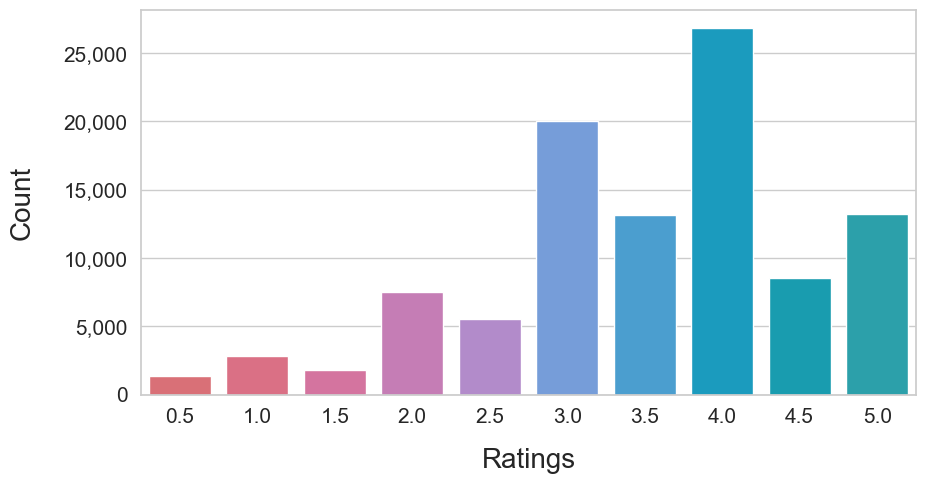

In [9]:
ratings_pd = pd.read_csv("../../data/ml-latest-small/ratings.csv")

# Create an array with the colors you want to use
# https://colordesigner.io/gradient-generator
# link generates a list of hex values between 2 given hexes
# Now I can match the powerpoint
hex_list = ["#eb5e68", "#ec5e7a", "#e4649d", "#d171bc", "#b580d4",
            "#669ae9", "#35a4e5", "#00abd9", "#00afc8", "#17b1bf"]
# Set your custom color palette
my_palette = sns.color_palette(hex_list, as_cmap=True)

plt.style.use('default')
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

plt.figure(figsize = (10, 5))
ax = sns.countplot(x="rating", data=ratings_pd, alpha=1, palette = my_palette)
plt.tick_params(labelsize = 15)
# plt.title("Distribution of Ratings in Movie Database", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20, labelpad=15)
plt.ylabel("Count", fontsize = 20,labelpad=20)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/ratings_dist.png', bbox_inches='tight', transparent=True);

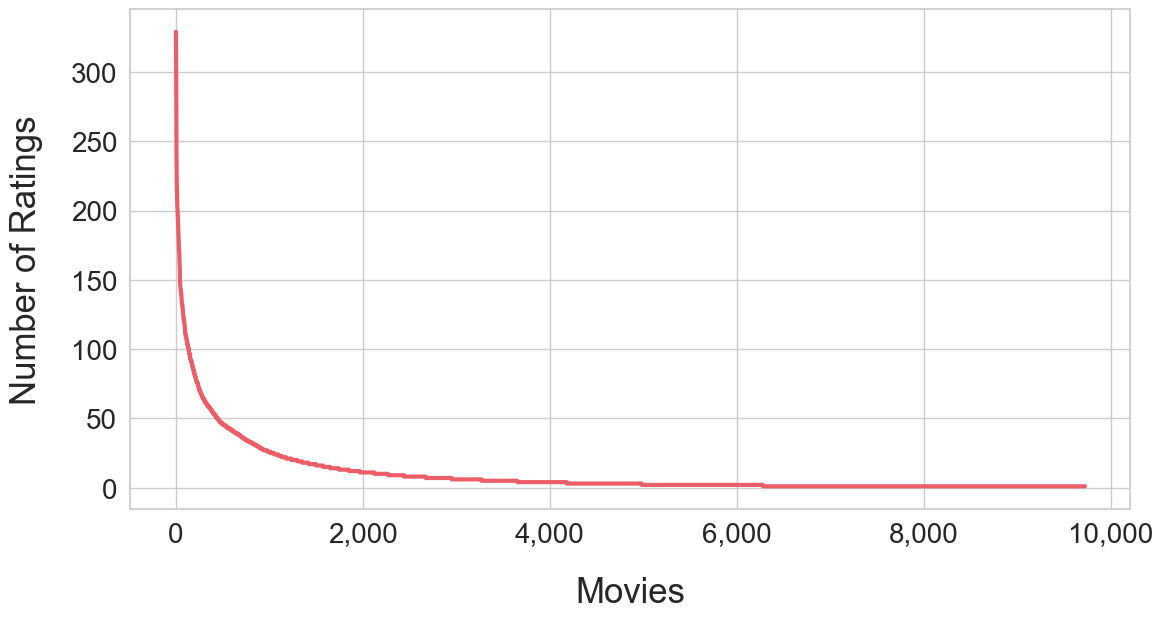

In [10]:
no_of_ratings_per_movie = ratings_pd.groupby(by = "movieId")["rating"].count().sort_values(ascending = False)

fig = plt.figure(figsize = (10, 5))
axes = fig.add_axes([0.1,0.1,1,1])
# plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movies", fontsize = 25, labelpad=20)
plt.ylabel("Number of Ratings", fontsize = 25, labelpad=20)
plt.plot(no_of_ratings_per_movie.values, color='#eb5e68', linewidth=3)
plt.tick_params(labelsize = 20)
#axes.set_xticklabels([])
axes.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/ratings_count_distribution.png', bbox_inches='tight', transparent=True);

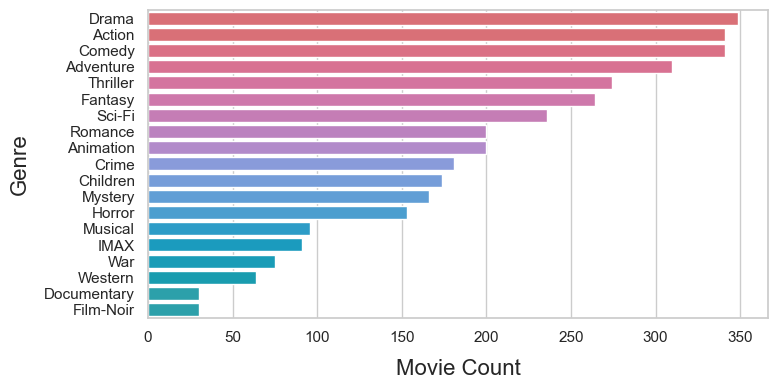

In [11]:
# Combine the genres and tags into one column and drop duplicates so that we have one movie per row
movies_pd = pd.read_csv("../../data/ml-latest-small/movies.csv")
movies_pd['genres'] = movies_pd['genres'].str.replace('|',' ')
movie_genres = movies_pd.genres.unique()
movie_genres = " ".join(movie_genres)
word_tokens = word_tokenize(movie_genres)
stopset = ['no', 'genres', 'listed', '(', ')']
cleanup = [token for token in word_tokens if token not in stopset]
bow = Counter(cleanup)
bow_dict = dict(bow)
bow_df = (pd.DataFrame.from_dict(bow_dict, orient='index', columns=["count"]))
bow_df.sort_values('count', ascending=False, inplace=True)
bow_df.reset_index(inplace=True)
bow_df.columns=['Genre', 'Movie Count']

# Create an array with the colors you want to use
# https://colordesigner.io/gradient-generator
# link generates a list of hex values between 2 given hexes
# Now I can match the powerpoint
hex_list = ["#eb5e68", "#eb5e68", "#ec5e7a", "#e9608c", "#e4649d",
            "#dc6aad", "#d171bc", "#c478c9", "#b580d4", "#7c94e7",
            "#669ae9", "#4e9fe8", "#35a4e5", "#14a7e0", "#00abd9",
            "#00add1", "#00afc8", "#17b1bf", "#17b1bf"]
# Set your custom color palette
my_palette = sns.color_palette(hex_list, as_cmap=True)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=bow_df['Movie Count'], y=bow_df['Genre'], alpha=1, palette = my_palette)
# ax.set_title("Genres by Frequency",fontsize=20)
ax.set_xlabel("Movie Count",fontsize=16, labelpad=10)
ax.set_ylabel("Genre",fontsize=16, labelpad=10)
# sns.despine(left=True)
plt.savefig('../../reports/figures/Genres.png', bbox_inches='tight', transparent=True);

## Collaborative Base Recommendation Engine

### Modeling

We conduct a train-test split separating data into training and testing sets for model training and evaluation on an 80/20 split respectively. 

The primary predictive model used in this project is Apache Spark ML Alternating Least Squares (ALS) for collaborative filtering. ALS recommender is a matrix factorization algorithm that uses Alternating Least Squares with Weighted-Lamda-Regularization (ALS-WR). It uses matrix multiplication with user ratings. As there are a lot of blank ratings (not every user has rated every movie), it predicts ratings for those blanks and recommneds movies based on those predictions. Our ALS model predicts top 5 rated movies for each user. After building our first simple model, and adjusting parameters, we run a param grid to identify the best performing model. We also build custom content based filtering predictive engines using Python. 

#### FSM

In [12]:
# Split the ratings dataframe into training and test data
(training_data, test_data) = df.randomSplit([.8, .2])

# Set the ALS hyperparameters
als_fsm = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative =True, implicitPrefs = False)

# Fit the model to the training_data
fsm = als_fsm.fit(training_data)

# Generate predictions on the test_data
test_predictions = fsm.transform(test_data)
test_predictions.show(10)

+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|userId|movieId|rating| timestamp|               title|              genres| tag|timestamp|prediction|
+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|   133|    471|   4.0| 843491793|Hudsucker Proxy, ...|              Comedy|null|     null| 2.6710997|
|   597|    471|   2.0| 941558175|Hudsucker Proxy, ...|              Comedy|null|     null|  4.470367|
|   602|    471|   4.0| 840876085|Hudsucker Proxy, ...|              Comedy|null|     null| 3.5580974|
|   555|    471|   3.0| 978746933|Hudsucker Proxy, ...|              Comedy|null|     null| 4.2579694|
|   136|    471|   4.0| 832450058|Hudsucker Proxy, ...|              Comedy|null|     null| 3.0938187|
|   312|    471|   4.0|1043175564|Hudsucker Proxy, ...|              Comedy|null|     null| 3.8283064|
|    44|    833|   2.0| 869252237|High School High ...|              Come

#### Build RMSE evaluator

Our ALS model is evaluated using the RMSE (Root Mean Squared Error) metric and our model’s RMSE score is 0.86 which is consistent with other published ALS recommender engines where the same dataset is used.

RMSE or Root Mean Squared Error is used as a measure of prediction accuracy. I.e. Given a set of items (movies) how well can the system predict my ratings for these items, or how well it can predict that i will watch these items.
RMSE is typically used to evaluate regression problems where the output (a predicted scalar value) is compared with the true scalar value output for a given data point, making it a good fit for our five star ratings evaluation.

In [13]:
# Complete the evaluator code
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [14]:
# Evaluate the "test_predictions" dataframe
RMSE = evaluator.evaluate(test_predictions)

# Print the RMSE
print (RMSE)

0.8744991441420507


#### Tuning Hyperparameters

In [15]:
# # Create ALS model
# als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
#           coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

In [16]:
# # Add hyperparameters and their respective values to param_grid
# param_grid = ParamGridBuilder() \
#             .addGrid(als.alpha, [0, .25, .5, .75, 1]) \
#             .addGrid(als.rank, [10, 25, 50, 75, 100]) \
#             .addGrid(als.regParam, [.05, .1, .15, .2]) \
#             .addGrid(als.maxIter, [5, 10, 15, 25, 50]) \
#             .build()


# print length of evaluator
# print ("Num models to be tested: ", len(param_grid))

In [17]:
# # Build cross validation using CrossValidator
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [18]:
# # Fit cross validator to the 'train' dataset
# model = cv.fit(train)

In [19]:
# # Extract best model from the cv model above
# best_model = model.bestModel

In [20]:
# # Extract the ALS model parameters
# print("**Best Model**")
# Print ("ParamMap")
# print("\n\n  ParamMap:", best_model._java_obj.parent().extractParamMap())

# # rank: 50
# # regParam=0.15
# # alpha=0
# # maxIter=10


#### Best Model

In [21]:
# New model with best params
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          alpha=0, rank=50, regParam=0.15, maxIter=10,
          coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
# Fit model to train
model = als.fit(training_data)

# Use mode to predict on test
test_predictions = model.transform(test_data)
test_predictions.show(10)

+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|userId|movieId|rating| timestamp|               title|              genres| tag|timestamp|prediction|
+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|   133|    471|   4.0| 843491793|Hudsucker Proxy, ...|              Comedy|null|     null| 2.7234366|
|   597|    471|   2.0| 941558175|Hudsucker Proxy, ...|              Comedy|null|     null| 4.2822337|
|   602|    471|   4.0| 840876085|Hudsucker Proxy, ...|              Comedy|null|     null| 3.2708027|
|   555|    471|   3.0| 978746933|Hudsucker Proxy, ...|              Comedy|null|     null| 3.8501942|
|   136|    471|   4.0| 832450058|Hudsucker Proxy, ...|              Comedy|null|     null| 3.5857515|
|   312|    471|   4.0|1043175564|Hudsucker Proxy, ...|              Comedy|null|     null| 3.6209443|
|    44|    833|   2.0| 869252237|High School High ...|              Come

In [22]:
# Evaluate the "test_predictions" dataframe
RMSE = evaluator.evaluate(test_predictions)

# Print the RMSE
print (RMSE)

0.8661151383045388


### Final recommendations

In [23]:
# Make 5 movie recommendations per user using their highest predicted ratings
recommendations = model.recommendForAllUsers(5)
# Print Some Prediction
recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("SELECT userId, movieIds_and_ratings.movieId AS movieId, movieIds_and_ratings.rating AS prediction FROM ALS_recs_temp LATERAL VIEW explode(recommendations) exploded_table AS movieIds_and_ratings")
clean_recs = clean_recs.join(movies, on=['movieId'], how='left').sort('userId')
clean_recs.show()

+-------+------+----------+--------------------+--------------------+
|movieId|userId|prediction|               title|              genres|
+-------+------+----------+--------------------+--------------------+
|   6375|     1|  5.676089|Gigantic (A Tale ...|         Documentary|
| 132333|     1|  5.676089|         Seve (2014)|   Documentary|Drama|
|   7071|     1|  5.462958|Woman Under the I...|               Drama|
| 117531|     1|  5.462958|    Watermark (2014)|         Documentary|
|   5490|     1|  5.676089|  The Big Bus (1976)|       Action|Comedy|
| 117531|     2|  4.605101|    Watermark (2014)|         Documentary|
|  84273|     2|  4.605101|Zeitgeist: Moving...|         Documentary|
|   7071|     2|  4.605101|Woman Under the I...|               Drama|
|  26073|     2|  4.605101|Human Condition I...|           Drama|War|
| 131724|     2| 4.8303237|The Jinx: The Lif...|         Documentary|
|   6835|     3|  4.842875|Alien Contaminati...|Action|Horror|Sci-Fi|
|   5181|     3| 4.7

In [24]:
# put in a random user number and return list of 5 titles
clean_recs

DataFrame[movieId: int, userId: int, prediction: float, title: string, genres: string]

In [25]:
df.filter(df["userId"]==168).filter(df["rating"]==5).show(10)
# Average ratings per user is 168
# user 168 rated 94 movies
# Rated 33 movies as 5 star
# Some of these 33 movies include Fargo, American Beauty,
# Dr. Strangelove, the graduate, Touching the Void

+------+-------+------+----------+--------------------+--------------------+----+---------+
|userId|movieId|rating| timestamp|               title|              genres| tag|timestamp|
+------+-------+------+----------+--------------------+--------------------+----+---------+
|   168|    608|   5.0|1306801670|        Fargo (1996)|Comedy|Crime|Dram...|null|     null|
|   168|    750|   5.0|1306801677|Dr. Strangelove o...|          Comedy|War|null|     null|
|   168|    858|   5.0|1306801724|Godfather, The (1...|         Crime|Drama|null|     null|
|   168|    908|   5.0|1306802820|North by Northwes...|Action|Adventure|...|null|     null|
|   168|    923|   5.0|1306801900| Citizen Kane (1941)|       Drama|Mystery|null|     null|
|   168|   1086|   5.0|1306801729|Dial M for Murder...|Crime|Mystery|Thr...|null|     null|
|   168|   1089|   5.0|1306802560|Reservoir Dogs (1...|Crime|Mystery|Thr...|null|     null|
|   168|   1172|   5.0|1306801666|Cinema Paradiso (...|               Drama|null

In [26]:
# Here's what we recommend to user 168
clean_recs.filter(clean_recs["userId"]==168).show(5, False)

+-------+------+----------+----------------------------------------------+-----------------+
|movieId|userId|prediction|title                                         |genres           |
+-------+------+----------+----------------------------------------------+-----------------+
|7767   |168   |5.1640215 |Best of Youth, The (La meglio gioventù) (2003)|Drama            |
|7096   |168   |5.145756  |Rivers and Tides (2001)                       |Documentary      |
|5490   |168   |5.050363  |The Big Bus (1976)                            |Action|Comedy    |
|6375   |168   |5.050363  |Gigantic (A Tale of Two Johns) (2002)         |Documentary      |
|132333 |168   |5.050363  |Seve (2014)                                   |Documentary|Drama|
+-------+------+----------+----------------------------------------------+-----------------+



# Cold Start Problem
What if the service aquires a new user? Our collaboration-based engine is based off a current user that has a history of ratings within the site. A user has to have a history in order for our model to return recommendations.
To combat this new user issue, known more formally as the Cold Start Problem, we develop two seperate engines that we can incorporate. The first engine gives the user the ability to input a move that they subjectively enjoyed in the past. It takes a movie title and spits out similar movies based on genres and user defined tags in our dataset.

## Content Based Recommender

In [27]:
# Combine the genres and tags into one column and drop duplicates so that we have one movie per row
tags_pd = pd.read_csv("../../data/ml-latest-small/tags.csv")
movies_pd = pd.read_csv("../../data/ml-latest-small/movies.csv")
content_pd = movies_pd.merge(tags_pd, on = "movieId", how='left')
content_pd.tag.fillna("", inplace=True)

# Separate the words in the genres column
content_pd['genres'] = content_pd['genres'].str.replace('|',' ')

# Since we have multiple tags for some movies from different users,
# we will make a combined tags column to combine those different tags for each movie
# and make a dataframe that has one row per movie
movie_Ids = content_pd.movieId.unique()
for movie in movie_Ids:
    m = content_pd[content_pd.movieId == movie]
    t = ""
    for x in m.values:
        if x[4] not in t:
            t+= x[4]+" "
    content_pd.loc[content_pd['movieId']==movie, 'combined_tags']=t
    
    
content_pd = content_pd[['movieId', 'title', 'genres', 'combined_tags']]
content_pd.drop_duplicates(inplace=True)
content_pd.reset_index(inplace=True)

In [28]:
features = ['combined_tags']

for feature in features:
    content_pd[feature] = content_pd[feature].fillna('')
    
content_pd["combined_features"] = content_pd.apply(rf.combine_features,axis=1)

In [29]:
sample_movies= ['Eternal Sunshine of the Spotless Mind (2004)', '28 Days Later (2002)',
                'Kung Fu Panda: Secrets of the Masters (2011)', '10 Things I Hate About You (1999)']

for movie in sample_movies:
    rf.similar_movies(content_pd, movie)


Top 5 similar movies to Eternal Sunshine of the Spotless Mind (2004) are:

Moonrise Kingdom (2012)
Donnie Darko (2001)
Teknolust (2002)
I'm a Cyborg, But That's OK (Saibogujiman kwenchana) (2006)
Buffalo '66 (a.k.a. Buffalo 66) (1998)

Top 5 similar movies to 28 Days Later (2002) are:

Hellraiser: Bloodline (1996)
Alien: Resurrection (1997)
Deep Rising (1998)
Alligator (1980)
Chopping Mall (a.k.a. Killbots) (1986)

Top 5 similar movies to Kung Fu Panda: Secrets of the Masters (2011) are:

Charlotte's Web (1973)
King and I, The (1999)
Doug's 1st Movie (1999)
Batman: Mask of the Phantasm (1993)
Tigger Movie, The (2000)

Top 5 similar movies to 10 Things I Hate About You (1999) are:

Rosencrantz and Guildenstern Are Dead (1990)
Much Ado About Nothing (1993)
Twelfth Night (1996)
Two if by Sea (1996)
French Twist (Gazon maudit) (1995)


### Visualize the genres and tags

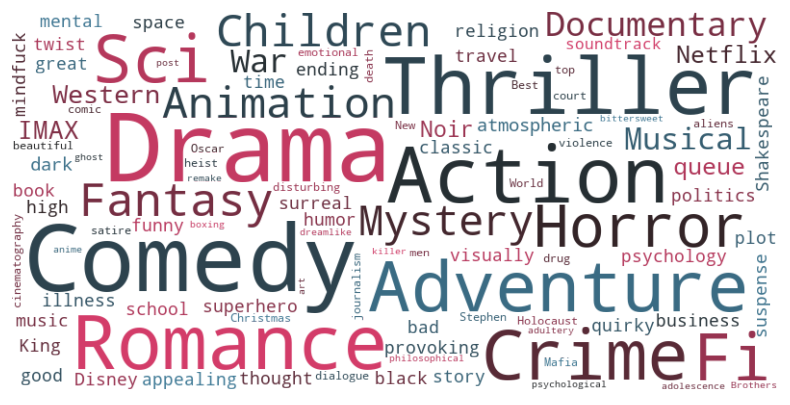

In [30]:
text = " ".join(feature for feature in content_pd["combined_features"])
stopwords = ['no', 'genres', 'listed', '(', ')', 'based', 'Film', 'movie', 'imdb',
             'of', 'Coen', 'and', 'II', 'a', 'the', 'r', 'in', 'on', 'will']
custom_palette = sns.diverging_palette(0, 230, l=50, center="dark", as_cmap=True)


# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, background_color="rgba(255, 255, 255, 0)", collocations=False,
                     max_font_size=100, margin=4, relative_scaling=.3, min_font_size=10, max_words=150,
                     width=800, height=400, colormap=custom_palette, mode="RGBA").generate(text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

In [31]:
wordcloud.to_file("../../reports/figures/word_cloud_3.png");

## Ratings Based General Recommender

The second cold start engine uses Bayesian Upper Confidence Bound Algorithm to determine which movies are the most favourable to recommend to a user without the user having ever seen a movie in their history.

In [32]:
# Import data fresh so as not to confuse it with other stuff, and merge
movies_df = pd.read_csv('../../data/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('../../data/ml-latest-small/ratings.csv')
movie_ratings = ratings_df.merge(movies_df, on=["movieId"])

# Add 'liked' column
movie_ratings["liked"] = movie_ratings['rating'].apply(lambda x: 1 if x >= 4.0 else 0)

# Call our newbayes function
rf.newbayes_ucb1_policy(movie_ratings, ucb_scale=2.0)

['Mission: Impossible - Fallout (2018)',
 "Metal: A Headbanger's Journey (2005)",
 'Deep End of the Ocean, The (1999)',
 'Program, The (1993)',
 'Take the Lead (2006)',
 'Down in the Valley (2005)']

## Summary
In summary, our team has developed 3 recommendation engines which can be used for a movie streaming service. We started by creating an ALS movie recommender model using collaborative filtering that will predict the top five movies for a user to view based on ratings by users similar to them. If a user is new to the service, we have presented two options. The first option is to use a content based filtering engine that outputs five movies per title based on a users liked titles while they are signing up for the movie service. The second option provides a list of five movies from the databse which our engine predicts are the most appealing without the user having to input any history. Using all three recommendation engines together, we present multiple options for your recommendation needs. As more movies, users, and ratings get added to the database, the recommendations will only get better.